# Ploomber Workshop Material

## 1. Introduction

Notebooks are an excellent environment for data exploration: they allow us to write code interactively and get visual feedback, providing an unbeatable experience for understanding our data.

However, this convenience comes at a cost: if we are not careful about adding and removing code cells, we may have an irreproducible notebook. Arbitrary execution order is a prevalent problem: A [recent analysis](https://blog.jetbrains.com/datalore/2020/12/17/we-downloaded-10-000-000-jupyter-notebooks-from-github-this-is-what-we-learned/) found that about 36% of notebooks on GitHub did not execute in linear order. To ensure our notebooks run, we must continuously test them to catch these problems.

A second notable problem is the size of notebooks: the more cells we have, the more difficult it is to debug since there are more variables and code involved.

Software engineers typically break down projects into multiple steps and test continuously to prevent broken and unmaintainable code. However, applying these ideas for data analysis requires extra work: multiple notebooks imply we have to ensure the output from one stage becomes the input for the next one. Furthermore, we can no longer press "Run all cells" in Jupyter to test our analysis from start to finish.

**Ploomber provides all the necessary tools to build multi-stage, reproducible pipelines in Jupyter that feel like a single notebook.** Users can easily break down their analysis into multiple notebooks and execute them all with a single command.

## 2. Refactoring a legacy notebook

If you already have a project in a single notebook, you can use our tool [Soorgeon](https://github.com/ploomber/soorgeon) to automatically refactor it into a [Ploomber](https://github.com/ploomber/ploomber) pipeline.
Since we'll be working with the `playground/` folder, we can set it to be the context.
Let's use the sample notebook in the `playground/` directory:

In [1]:
%cd playground

/home/jovyan/ploomber-workshop/playground


In [2]:
%%sh
ls

nb.ipynb
output
pipeline.png
pipeline.yaml
README.md
requirements.txt
tasks


Our sample notebook is the [`nb.ipynb`](playground/nb.ipynb) file, let's take a look at it.

To refactor the notebook, we use the `soorgeon refactor` command:

In [4]:
%%sh
soorgeon refactor nb.ipynb

Added 'output' directory to .gitignore...
README.md found, appended auto-generated content
Finished refactoring 'nb.ipynb', use Ploomber to continue.

Install dependencies (this will install ploomber):
    $ pip install -r requirements.txt

List tasks:
    $ ploomber status

Execute pipeline:
    $ ploomber build

Plot pipeline (this requires pygraphviz, which isn't installed by default):
    $ ploomber plot

* Documentation: https://docs.ploomber.io
* Jupyter integration: https://ploomber.io/s/jupyter
* Other editors: https://ploomber.io/s/editors



Let's take a look at the directory:

In [5]:
%%sh
ls 

nb.ipynb
pipeline.png
pipeline.yaml
README.md
requirements.txt
tasks


We can see that we have a few new files. `pipeline.yaml` contains the pipeline declaration, and `tasks/` contains the *stages* that Soorgeon identified based on our H2 Markdown headings.

In [6]:
%%sh
ls tasks

clean.ipynb
linear-regression.ipynb
load.ipynb
random-forest-regressor.ipynb
train-test-split.ipynb


Let's plot the pipeline (note that we're now using `ploomber`, which is the framework for developing pipelines:

In [7]:
%%sh
ploomber plot

Loading pipeline...
Plot saved at: pipeline.png


100%|██████████| 5/5 [00:00<00:00, 15615.43it/s]


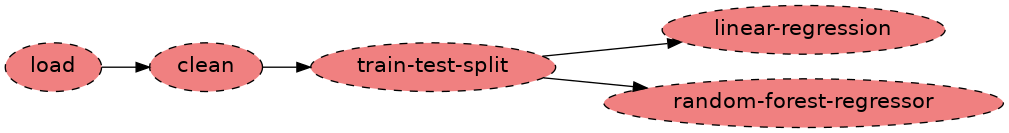

In [8]:
from IPython.display import Image
Image('pipeline.png')

Soorgeon correctly identified the *stages* in our original `nb.ipynb` notebook. It even detected that the last two tasks (`linear-regression`, and `random-forest-regressor` are independenf of each other!).

We can also get a summary of the pipeline with `ploomber status`:

In [ ]:
%%sh
ploomber status

Loading pipeline...
name         Last run    Outdated?    Product      Doc        Location
                                                   (short)
-----------  ----------  -----------  -----------  ---------  -----------
load         Has not     Source code  MetaProduct             /home/jovya
             been run                 ({'df': Fil             n/ploomber-
                                      e('output/l             workshop/pl
                                      oad-                    ayground/ta
                                      df.pkl'),               sks/load.ip
                                      'nb': File(             ynb
                                      'output/loa
                                      d.ipynb')})
clean        Has not     Source code  MetaProduct             /home/jovya
             been run    & Upstream   ({'df': Fil             n/ploomber-
                                      e('output/c             workshop/pl
                  

100%|██████████| 5/5 [00:00<00:00, 15756.21it/s]


## 3. The `pipeline.yaml` file

To develop a pipeline, users create a `pipeline.yaml` file and declare the tasks and their outputs as follows:

```yaml
tasks:
  - source: script.py
    product:
      nb: output/executed.ipynb
      data: output/data.csv
  
  # more tasks here...
```

The previous pipeline has a single task (`script.py`) and generates two outputs: `output/executed.ipynb` and `output/data.csv`. You may be wondering why we have a notebook as an output: Ploomber converts scripts to notebooks before execution; hence, our script is considered the source and the notebook a byproduct of the execution. Using scripts as sources (instead of notebooks) makes it simpler to use git. However, this does not mean you have to give up interactive development since Ploomber integrates with Jupyter, allowing you to edit scripts as notebooks.


In this case, since we used `soorgeon` to refactor an existing notebook, we didn't have to write the `pipeline.yaml` file, let's take a look at the auto-generated one: [`pipeline.yaml`](playground/pipeline.yaml).


## 4. Building the pipeline

Let's build the pipeline (this will take ~30 seconds):

In [ ]:
%%sh
ploomber build

Loading pipeline...
name                     Ran?      Elapsed (s)    Percentage
-----------------------  ------  -------------  ------------
load                     True          3.05583      13.5435
clean                    True          6.47916      28.7157
train-test-split         True          2.24937       9.96926
linear-regression        True          3.51657      15.5855
random-forest-regressor  True          7.26216      32.186


Building task 'random-forest-regressor': 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


Navigate to `playground/output/` and you'll see all the outputs: the executed notebooks, data files and trained model.

In [11]:
%%sh
ls output

clean-df.pkl
clean.ipynb
linear-regression.ipynb
load-df.pkl
load.ipynb
random-forest-regressor.ipynb
train-test-split.ipynb
train-test-split-X_test.pkl
train-test-split-X_train.pkl
train-test-split-y_test.pkl
train-test-split-y_train.pkl


## 5. Testing and quality checks

####  Open `tasks/train-test-split.ipynb` as a notebook by right-clicking on it and then `Open With` -> `Notebook` and add the following code after the cell with `# noqa`:

```python
# Sample data quality checks after loading the raw data
# Check nulls
assert not df['HouseAge'].isnull().values.any() 

# Check a specific range - no outliers
assert df['HouseAge'].between(0,100).any()

# Exact expected row count
assert len(df) == 11085
```

#### We'll do the same for `tasks/linear-regression.ipynb`, open the file and add the tests:
```python
# Sample tests after the notebook ran
# Check task test input exists
assert Path(upstream['train-test-split']['X_test']).exists

# Check task train input exists
assert Path(upstream['train-test-split']['y_train']).exists

# Validating output type
assert 'pkl' in upstream['train-test-split']['X_test']
```

In [12]:
%%sh
ploomber build

Loading pipeline...
name                     Ran?      Elapsed (s)    Percentage
-----------------------  ------  -------------  ------------
load                     False               0             0
clean                    False               0             0
train-test-split         False               0             0
linear-regression        False               0             0
random-forest-regressor  False               0             0


0it [00:00, ?it/s]


## 6. Maitaining the pipeline

Let's look again at our pipeline plot:

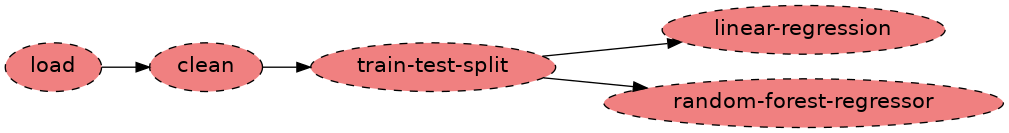

In [13]:
Image('pipeline.png')

The arrows in the diagram represent input/output relations, hence, determine execution order. For example, the first task (`load`) loads some data, then `clean` uses such data as input and process it, then `train-test-split` splits our dataset in training and test, finally, we use those datasets to train a linear regression and a random forest regressor.

Soorgeon extracted and declared this dependencies for us, but if we want to modify the existing pipeline, we need to declare such dependencies. Let's see how.


## 7. Adding a new task

Let's say we want to train another model and decide to try [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor). First, we modify the `pipeline.yaml` file and add a new task:

####  Open `pipeline.yaml` and add the following lines at the end

```yaml
- source: tasks/gradient-boosting-regressor.py
  product:
    nb: output/gradient-boosting-regressor.ipynb
```

Now, let's create a base file by executing `ploomber scaffold`:

In [14]:
%%sh
ploomber scaffold

Found spec at 'pipeline.yaml'
All tasks sources declared in 'pipeline.yaml' exist, nothing was created.


Let's see how the plot looks now:

In [15]:
%%sh
ploomber plot

Loading pipeline...
Plot saved at: pipeline.png


100%|██████████| 5/5 [00:00<00:00, 13565.02it/s]


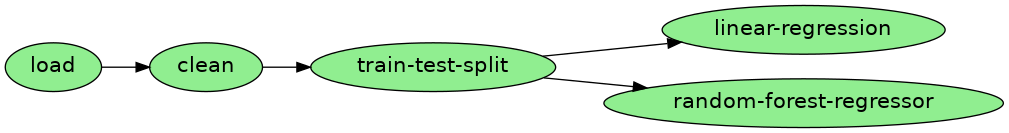

In [16]:
from IPython.display import Image
Image('pipeline.png')

You can see that Ploomber recognizes the new file, but it doesn't have any dependency, so let's tell Ploomber that it should execute after `train-test-split`:

####  Open `tasks/gradient-boosting-regressor.py` as a notebook by right-clicking on it and then `Open With` -> `Notebook`:

![lab-open-with-notebook](images/lab-open-with-notebook.png)

At the top of the notebook, you'll see the following:

```python
upstream = None
```

This special variable indicates which tasks should execute before the notebook we're currently working on. In this case, we want to get training data so we can train our new model so we change the `upstream` variable:

```python
upstream = ['train-test-split']
```

Let's generate the plot again:

In [ ]:
%%sh
ploomber plot

In [ ]:
from IPython.display import Image
Image('pipeline.png')

Ploomber now recognizes our new node!

####  Open `tasks/gradient-boosting-regressor.py` as a notebook by right-clicking on it and then `Open With` -> `Notebook` and add the following code:

```python
from pathlib import Path
import pickle

import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor

y_train = pickle.loads(Path(upstream['train-test-split']['y_train']).read_bytes())
y_test = pickle.loads(Path(upstream['train-test-split']['y_test']).read_bytes())
X_test = pickle.loads(Path(upstream['train-test-split']['X_test']).read_bytes())
X_train = pickle.loads(Path(upstream['train-test-split']['X_train']).read_bytes())

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred)
```


## 8. Incremental builds

Data workflows require a lot of iteration. For example, you may want to generate a new feature or model. However, it's wasteful to re-execute every task with every minor change. Therefore, one of Ploomber's core features is incremental builds, which automatically skip tasks whose source code hasn't changed.

Run the pipeline again:

In [ ]:
%%sh
ploomber build

You can see that only the `gradient-boosting-regressor` task ran!

Incremental builds allow us to iterate faster without keeping track of task changes.

Check out [`playground/output/gradient-boosting-regressor.ipynb`](playground/output/gradient-boosting-regressor.ipynb), which contains the output notebooks with the model evaluation plot.

## 9. Parallel execution + Ploomber cloud execution
This section can run locally or on the cloud.
To setup the cloud we'll need to register for an api key, and make sure we have the right version:


Ploomber cloud allows you to scale your experiments into the cloud without provisioning machines and without dealing with infrastrucutres. 
####  Open `playground/pipeline.yaml` and add the following co instead of the source task:
```yaml
- source: tasks/random-forest-regressor.ipynb
```

This is how your task should look like in the end
```yaml
- source: tasks/random-forest-regressor.ipynb
  name: random-forest-
  product:
    nb: output/random-forest-regressor.ipynb
  grid:
        # creates 6 tasks (2 * 2)
        n_estimators: [5, 10]
        criterion: [gini, entropy]
```

In [ ]:
%%sh
ploomber plot

In [ ]:
from IPython.display import Image
Image('pipeline.png')

In [ ]:
%%sh
ploomber build

## 8. Execution in the cloud

When working with datasets that fit in memory, running your pipeline is simple enough, but sometimes you may need more computing power for your analysis. Ploomber makes it simple to execute your code in a distributed environment without code changes.

Check out [Soopervisor](https://soopervisor.readthedocs.io), the package that implements exporting Ploomber projects in the cloud with support for:

* [Kubernetes (Argo Workflows)](https://soopervisor.readthedocs.io/en/latest/tutorials/kubernetes.html)
* [AWS Batch](https://soopervisor.readthedocs.io/en/latest/tutorials/aws-batch.html)
* [Airflow](https://soopervisor.readthedocs.io/en/latest/tutorials/airflow.html)

# 9. Resources

Thanks for taking the time to go through this tutorial! We hope you consider using Ploomber for your next project. If you have any questions or need help, please reach out to us! (contact info below).

Here are a few resources to dig deeper:

* [GitHub](https://github.com/ploomber/ploomber)
* [Documentation](https://ploomber.readthedocs.io/)
* [Code examples](https://github.com/ploomber/projects)
* [JupyterCon 2020 talk](https://www.youtube.com/watch?v=M6mtgPfsA3M)
* [Argo Community Meeting talk](https://youtu.be/FnpXyg-5W_c)
* [Pangeo Showcase talk (AWS Batch demo)](https://youtu.be/XCgX1AszVF4)

# 10. Contact

* Join us on Slack: [http://ploomber.io/community](http://ploomber.io/community)
* Twitter: [@ploomber](https://twitter.com/ploomber)
* E-mail: [contact@ploomber.io](mailto:contact@ploomber.io)